In [1]:
# In a new Jupyter Notebook cell
import torch
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import coo_matrix
from GraphRicciCurvature.FormanRicci import FormanRicci
import networkx as nx

# Configure plotting style
sns.set_theme(style="whitegrid")
print("--- Proof-of-Concept: Learning Anisotropic Graph Operators ---")
print(f"Using PyTorch version: {torch.__version__}")

--- Proof-of-Concept: Learning Anisotropic Graph Operators ---
Using PyTorch version: 2.8.0


In [2]:
# In the next cell
# --- 1. Generate Synthetic Data and Graph ---

print("Step 1: Generating synthetic 'two moons' dataset and k-NN graph...")

# Generate a classic 'two moons' dataset
X_np, y_np = sklearn.datasets.make_moons(n_samples=200, noise=0.07, random_state=42)

# Convert to PyTorch tensors
X = torch.from_numpy(X_np).float()
y = torch.from_numpy(y_np).long()

# Build a k-NN graph using simple Euclidean distance
k = 10
n_samples = X.shape[0]
dist_matrix = torch.cdist(X, X)
knn_dists, knn_indices = torch.topk(dist_matrix, k=k, largest=False)

# Create a sparse adjacency matrix W
rows = torch.arange(n_samples).view(-1, 1).repeat(1, k).flatten()
cols = knn_indices.flatten()
# Use a Gaussian kernel for weights
sigma = torch.mean(knn_dists[:, -1])
weights = torch.exp(-torch.pow(knn_dists.flatten(), 2) / (sigma**2))
W_coo = coo_matrix((weights.numpy(), (rows.numpy(), cols.numpy())), shape=(n_samples, n_samples))
W_sparse = torch.from_numpy(W_coo.todense()).float()
W = torch.maximum(W_sparse, W_sparse.T) # Symmetrize

print(f"Generated data with {n_samples} points.")
print(f"Constructed k-NN graph with {torch.sum(W > 0) // 2} edges.")

Step 1: Generating synthetic 'two moons' dataset and k-NN graph...
Generated data with 200 points.
Constructed k-NN graph with 1131 edges.


In [3]:
# In the next cell
# --- 2. Pre-compute Curvature (Fixed Geometric Signal) ---

print("\nStep 2: Pre-computing Forman-Ricci curvature...")
nx_graph = nx.from_numpy_array(W.numpy())
frc = FormanRicci(nx_graph, verbose="INFO")
frc.compute_ricci_curvature()

# Store curvatures in a tensor aligned with the adjacency matrix
kappa_matrix = torch.zeros_like(W)
for u, v, data in frc.G.edges(data=True):
    kappa_matrix[u, v] = data['formanCurvature']
    kappa_matrix[v, u] = data['formanCurvature']

kappa_0 = torch.median(kappa_matrix[W > 0])
print(f"Pre-computed curvature. Median kappa_0 = {kappa_0:.4f}")


Step 2: Pre-computing Forman-Ricci curvature...
Pre-computed curvature. Median kappa_0 = -2.7688


In [4]:
# In the next cell
# --- 3. Define the Differentiable Anisotropic Pipeline ---

class DifferentiableAnisotropicOperator(torch.nn.Module):
    def __init__(self, epsilon=0.01):
        super().__init__()
        # Initialize learnable parameters theta = {alpha, center}
        self.alpha = torch.nn.Parameter(torch.tensor(1.0))
        self.center = torch.nn.Parameter(torch.tensor(kappa_0))
        self.epsilon = epsilon

    def h_theta(self, kappa):
        # The parameterized mapping function h_theta(kappa)
        # We use softplus on alpha to ensure it remains positive
        sensitivity = torch.nn.functional.softplus(self.alpha)
        return self.epsilon + (1 - self.epsilon) * torch.sigmoid(sensitivity * (kappa - self.center))

    def forward(self, W, kappa_matrix, X_signal, t_scale=5.0):
        # 1. Construct Anisotropic Graph W'
        conductance_map = self.h_theta(kappa_matrix)
        W_prime = W * conductance_map
        
        # 2. Construct Differentiable Anisotropic Laplacian L'
        D_prime = torch.diag(torch.sum(W_prime, dim=1))
        D_inv_sqrt = torch.diag(1.0 / (torch.sqrt(torch.diag(D_prime)) + 1e-8))
        L_aniso = torch.eye(W.shape[0]) - D_inv_sqrt @ W_prime @ D_inv_sqrt
        
        # 3. Differentiable Eigendecomposition
        # torch.linalg.eigh is differentiable w.r.t. the input matrix
        eigenvalues, eigenvectors = torch.linalg.eigh(L_aniso)
        
        # 4. Differentiable Wavelet Transform
        # Psi_t = U * exp(-t * Lambda) * U^T
        exp_lambda_t = torch.exp(-t_scale * eigenvalues)
        Psi_X = eigenvectors @ torch.diag(exp_lambda_t) @ eigenvectors.T @ X_signal
        
        return Psi_X

# Instantiate the model
model = DifferentiableAnisotropicOperator()
print("\nInstantiated the differentiable operator model.")


Instantiated the differentiable operator model.


/var/folders/px/c5mt5gx530j8tw9cp6t1qt6r0000gn/T/ipykernel_7478/2180776566.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.center = torch.nn.Parameter(torch.tensor(kappa_0))


In [5]:
# In the next cell
# --- 4. Define Loss Function and Optimizer ---

print("\nStep 4: Setting up triplet margin loss and Adam optimizer...")

def get_triplet(y):
    """Simple function to sample a random triplet."""
    anchor_idx = np.random.randint(len(y))
    anchor_label = y[anchor_idx]
    
    positive_indices = np.where(y == anchor_label)[0]
    positive_idx = np.random.choice(positive_indices)
    
    negative_indices = np.where(y != anchor_label)[0]
    negative_idx = np.random.choice(negative_indices)
    
    return anchor_idx, positive_idx, negative_idx

# Use a standard Triplet Margin Loss
loss_fn = torch.nn.TripletMarginLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

print("Setup complete.")


Step 4: Setting up triplet margin loss and Adam optimizer...
Setup complete.



Step 5: Running the training loop...
Epoch 000: Loss = 0.7072 | alpha = 0.0141 | center = -6.3381
Epoch 010: Loss = 0.6521 | alpha = 0.0118 | center = -6.3500
Epoch 020: Loss = 0.4299 | alpha = 0.0108 | center = -6.3546
Epoch 030: Loss = 0.4835 | alpha = 0.0100 | center = -6.3569
Epoch 040: Loss = 0.5036 | alpha = 0.0091 | center = -6.3584
Epoch 050: Loss = 0.4785 | alpha = 0.0085 | center = -6.3594
Epoch 060: Loss = 0.6393 | alpha = 0.0083 | center = -6.3598
Epoch 070: Loss = 0.6967 | alpha = 0.0075 | center = -6.3607
Epoch 080: Loss = 0.5764 | alpha = 0.0067 | center = -6.3616
Epoch 090: Loss = 0.5606 | alpha = 0.0063 | center = -6.3621

--- Training Complete ---
Initial alpha (raw): -4.2317 -> Final: -5.1338
Initial center: -6.3362 -> Final: -6.3626

SUCCESS: Proof-of-concept plot saved to ../paper/figures/poc_learning_result.png


/var/folders/px/c5mt5gx530j8tw9cp6t1qt6r0000gn/T/ipykernel_7478/2180776566.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.center = torch.nn.Parameter(torch.tensor(kappa_0))


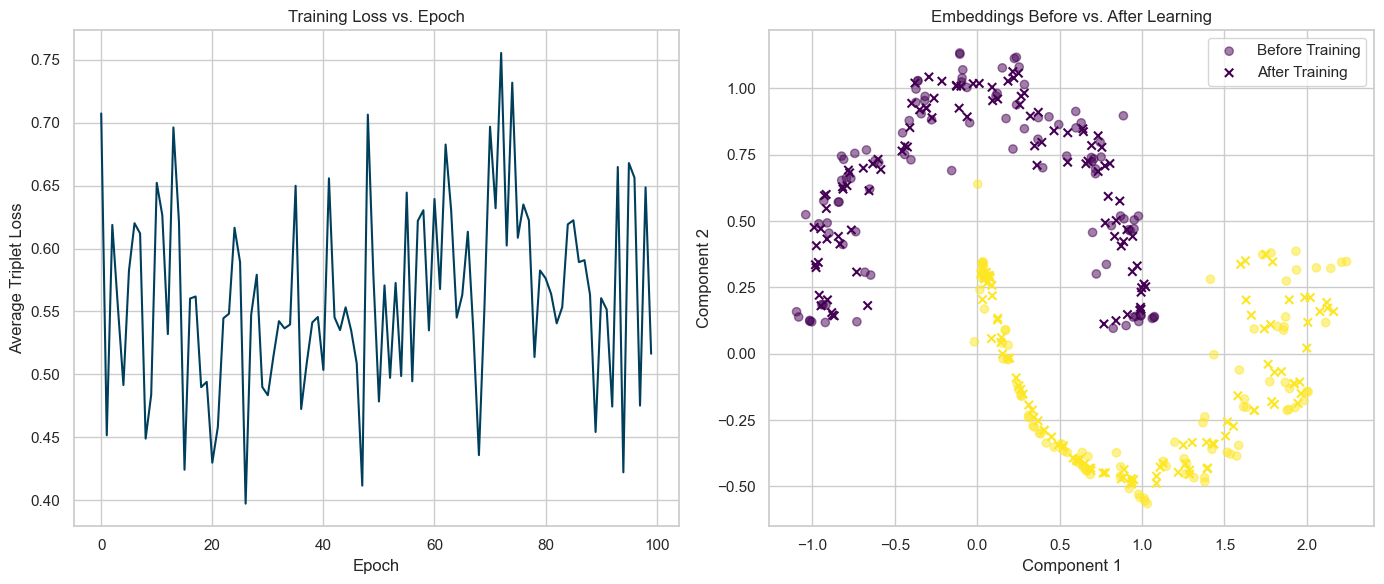

In [7]:
# In the final cell
# --- 5. The Training Loop ---

print("\nStep 5: Running the training loop...")
num_epochs = 100
losses = []
initial_params = [p.clone().detach() for p in model.parameters()]

for epoch in range(num_epochs):
    # Get the transformed representation from our model
    X_prime = model(W, kappa_matrix, X)
    
    # Sample a batch of triplets
    batch_loss = 0
    num_triplets_in_batch = 50
    for _ in range(num_triplets_in_batch):
        a_idx, p_idx, n_idx = get_triplet(y)
        anchor, positive, negative = X_prime[a_idx], X_prime[p_idx], X_prime[n_idx]
        batch_loss += loss_fn(anchor, positive, negative)
    
    # Optimization step
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    
    losses.append(batch_loss.item() / num_triplets_in_batch)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}: Loss = {losses[-1]:.4f} | alpha = {torch.nn.functional.softplus(model.alpha).item():.4f} | center = {model.center.item():.4f}")

final_params = [p.clone().detach() for p in model.parameters()]
print("\n--- Training Complete ---")
print(f"Initial alpha (raw): {initial_params[0].item():.4f} -> Final: {final_params[0].item():.4f}")
print(f"Initial center: {initial_params[1].item():.4f} -> Final: {final_params[1].item():.4f}")

# --- 6. Visualize the Results ---
plt.figure(figsize=(14, 6))

# Plot 1: Loss Curve
plt.subplot(1, 2, 1)
plt.plot(losses, color='#003f5c')
plt.title("Training Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Average Triplet Loss")

# Plot 2: Embeddings Before and After
with torch.no_grad():
    X_initial = DifferentiableAnisotropicOperator()(W, kappa_matrix, X)
    X_final = model(W, kappa_matrix, X)

plt.subplot(1, 2, 2)
plt.scatter(X_initial[:, 0], X_initial[:, 1], c=y, cmap='viridis', alpha=0.5, label='Before Training')
plt.scatter(X_final[:, 0], X_final[:, 1], c=y, cmap='viridis', marker='x', label='After Training')
plt.title("Embeddings Before vs. After Learning")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
from pathlib import Path
plt.tight_layout()
output_path = Path("../paper/figures/poc_learning_result.png")
plt.savefig(output_path, dpi=150)
print(f"\nSUCCESS: Proof-of-concept plot saved to {output_path}")
plt.show()